<a href="https://colab.research.google.com/github/sarathshiva/Project/blob/main/Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Fraud Detection**

This case requires trainees to develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan. Data for the case is available in CSV format having 6362620 rows and 10 columns. Candidates can use whatever method they wish to develop their machine learning model. Following usual model development procedures, the model would be estimated on the calibration data and tested on the validation data. This case requires both statistical analysis and creativity/judgment. We recommend you spend time on both fine-tuning and interpreting the results of your machine learning model.

**Here is the information on this particular data set:**

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


## Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [ ]:
path = "/content/drive/MyDrive/Fraud.csv"

In [ ]:
df=  pd.read_csv(path)

In [ ]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [ ]:
# Shape of the dataset -
print("No. of rows: ", df.shape[0])
print("No. of columns: ", df.shape[1])

No. of rows:  6362620
No. of columns:  11


In [ ]:
# Checking the distribution of outcome labels -
df.isFraud.value_counts(normalize=True)*100

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

In [ ]:
# Displays memory consumed by each column ---
print(df.memory_usage())

Index                  128
step              50900960
type              50900960
amount            50900960
nameOrig          50900960
oldbalanceOrg     50900960
newbalanceOrig    50900960
nameDest          50900960
oldbalanceDest    50900960
newbalanceDest    50900960
isFraud           50900960
isFlaggedFraud    50900960
dtype: int64


In [ ]:
# space used by data
print('Dataset uses {0} MB'.format(df.memory_usage().sum()/1024**2))

Dataset uses 533.9724426269531 MB


**2. Exploratory Data Analysis**

In this section and until section 4, we wrangle with the data exclusively using Dataframe methods. This is the most succinct way to gain insights into the dataset. More elaborate visualizations follow in subsequent sections.

In [ ]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df['nameOrig'] = df['nameOrig'].astype('str')
df['nameDest'] = df['nameDest'].astype('str')
df['type'] = df['type'].astype('str')

In [ ]:
convert_dict = {'step': np.int8,
                'isFraud': np.int8,
                'isFlaggedFraud':np.int8, 
                'amount':np.float16,
                'newbalanceOrig' :np.float16,
                'oldbalanceDest' :np.float16,
                'oldbalanceDest':np.float16,
                'newbalanceDest':np.float16
                }
 
df = df.astype(convert_dict)

In [ ]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int8   
 1   type            object 
 2   amount          float16
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float16
 6   nameDest        object 
 7   oldbalanceDest  float16
 8   newbalanceDest  float16
 9   isFraud         int8   
 10  isFlaggedFraud  int8   
dtypes: float16(4), float64(1), int8(3), object(3)
memory usage: 260.9+ MB


Memory usage resuce from 534 Mb to 260.9 MB

### Key Takeaways:
<a id='KeyTake'></a>
1. There are no missing values
2. There are just over 6 million observations
3. There are 11 variables
4. Most transactions involve amounts less than 1 million euros.
5. Most observations in the dataset are of valid transactions, so any patterns related to identifying fraud transactions may be hard to see, data is also unbalanced.
6. From the sample of observations, there are many instances where what happens to the recipient account (oldbalanceDest, newbalanceDest) does not make sense (e.g. the very first observation involved a payment of 9839.64 yet, the balance before and after the transaction equals 0.) 


#### Correlation Heatmap -

A correlation heatmap is a heatmap that shows a 2D correlation matrix between two discrete dimensions, using colored cells to represent data from usually a monochromatic scale. The values of the first dimension appear as the rows of the table while of the second dimension as a column. The color of the cell is proportional to the number of measurements that match the dimensional value. This makes correlation heatmaps ideal for data analysis since it makes patterns easily readable and highlights the differences and variation in the same data. A correlation heatmap, like a regular heatmap, is assisted by a colorbar making data easily readable and comprehensible.

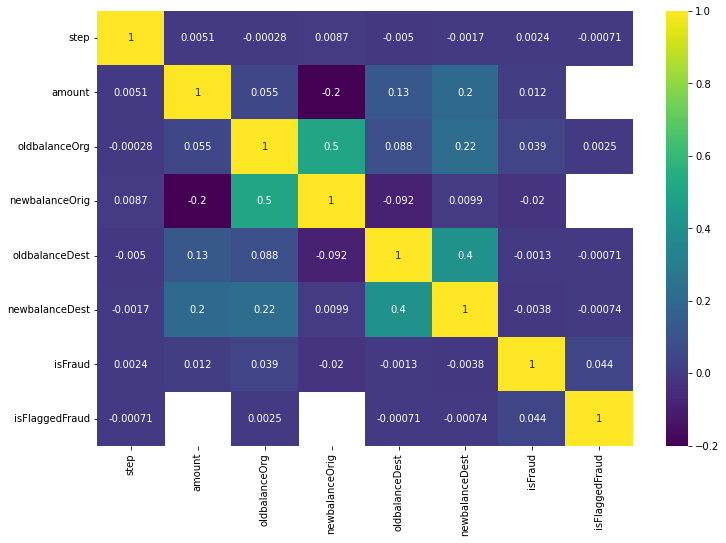

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(method='spearman'), annot=True, cmap='viridis')
plt.show()

We noticed almost perfect correlation between "oldbalanceDest" the "newbalanceDest" feature. 

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

So, we can drop either one of those columns.

In [ ]:
df.drop(columns=['oldbalanceDest'], axis=1, inplace=True)

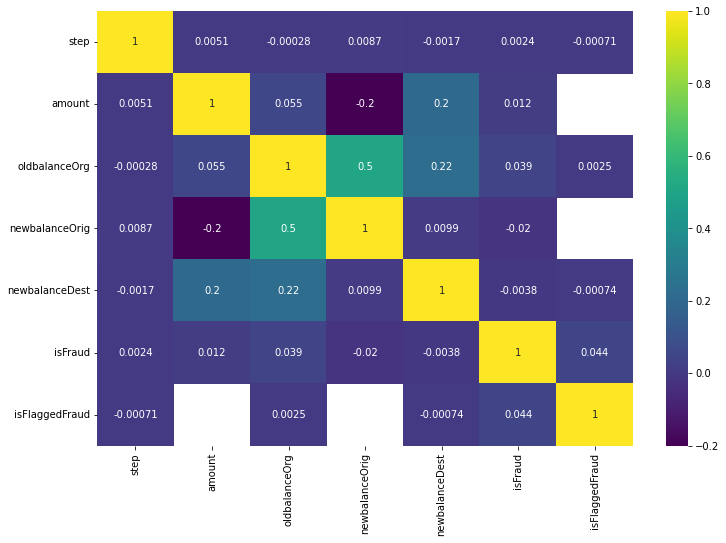

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(method='spearman'), annot=True, cmap='viridis')
plt.show()

In [ ]:
df.groupby(by='type').describe().T

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


type                       CASH_IN      CASH_OUT         DEBIT       PAYMENT  \
step           count  1.399284e+06  2.237500e+06  4.143200e+04  2.151495e+06   
               mean  -5.901187e+00 -6.231997e+00 -1.498117e+00 -4.312091e+00   
               std    7.367904e+01  7.337487e+01  7.445766e+01  7.316768e+01   
               min   -1.280000e+02 -1.280000e+02 -1.280000e+02 -1.280000e+02   
               25%   -7.300000e+01 -7.300000e+01 -7.200000e+01 -7.100000e+01   
               50%    8.000000e+00  8.000000e+00  1.200000e+01  9.000000e+00   
               75%    4.600000e+01  4.500000e+01  5.200000e+01  4.700000e+01   
               max    1.270000e+02  1.270000e+02  1.270000e+02  1.270000e+02   
amount         count  1.399284e+06  2.237500e+06  4.143200e+04  2.151495e+06   
               mean            NaN           NaN           inf           NaN   
               std             NaN           NaN           NaN           NaN   
               min    4.000854e-02  0.000000e+00  5.498047e-01  2.000427e-02   
               25%             NaN           NaN  1.500000e+03  4.384000e+03   
               50%             NaN           NaN  3.049000e+03  9.480000e+03   
               75%             NaN           NaN  5.480000e+03  1.756800e+04   
               max             inf           inf           inf           inf   
oldbalanceOrg  count  1.399284e+06  2.237500e+06  4.143200e+04  2.151495e+06   
               mean   3.590464e+06  4.602380e+04  6.864734e+04  6.821683e+04   
               std    5.291825e+06  1.791326e+05  1.384493e+05  1.989911e+05   
               min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
               25%    3.776800e+04  0.000000e+00  1.518500e+03  0.000000e+00   
               50%    1.200093e+06  5.560000e+02  2.082111e+04  1.053000e+04   
               75%    5.284255e+06  3.144624e+04  6.880661e+04  6.088300e+04   
               max    3.893942e+07  4.381886e+07  4.362014e+06  4.368662e+07   
newbalanceOrig count  1.399284e+06  2.237500e+06  4.143200e+04  2.151495e+06   
               mean            NaN           NaN           inf           NaN   
               std             NaN           NaN           NaN           NaN   
               min    5.441406e+00  0.000000e+00  0.000000e+00  0.000000e+00   
               25%             NaN  0.000000e+00  0.000000e+00  0.000000e+00   
               50%             NaN  0.000000e+00  1.663200e+04  0.000000e+00   
               75%             NaN  0.000000e+00  6.262400e+04  4.966400e+04   
               max             inf           inf           inf           inf   
newbalanceDest count  1.399284e+06  2.237500e+06  4.143200e+04  2.151495e+06   
               mean            NaN           NaN           inf  0.000000e+00   
               std             NaN           NaN           NaN  0.000000e+00   
               min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
               25%    4.275200e+04           NaN           NaN  0.000000e+00   
               50%             NaN           NaN           NaN  0.000000e+00   
               75%             NaN           NaN           NaN  0.000000e+00   
               max             inf           inf           inf  0.000000e+00   
isFraud        count  1.399284e+06  2.237500e+06  4.143200e+04  2.151495e+06   
               mean   0.000000e+00  1.839553e-03  0.000000e+00  0.000000e+00   
               std    0.000000e+00  4.285055e-02  0.000000e+00  0.000000e+00   
               min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
               25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
               50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
               75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
               max    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
isFlaggedFraud count  1.399284e+06  2.237500e+06  4.143200e+04  2.151495e+06   


The majority of people have use "CASH_OUT" and "PAYMENT".

**Feature Engineering**

In [ ]:
data_new = df.copy() # creating copy of dataset in case I need original dataset

In [ ]:
data_new["type1"] = np.nan # initializing feature column

# filling feature column
data_new.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C'),"type1"] = "CC" 
data_new.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('M'),"type1"] = "CM"
data_new.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'),"type1"] = "MC"
data_new.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('M'),"type1"] = "MM"

In [ ]:
# Subsetting data into observations with fraud and valid transactions:
fraud = data_new[data_new["isFraud"] == 1]
valid = data_new[data_new["isFraud"] == 0]
# seeing the counts of transactions by type1 (CC,CM,MC,MM)
print("Fraud transactions by type1: \n",fraud.type1.value_counts())
print("\n Valid transactions by type1: \n",valid.type1.value_counts())

Fraud transactions by type1: 
 CC    8213
Name: type1, dtype: int64

 Valid transactions by type1: 
 CC    4202912
CM    2151495
Name: type1, dtype: int64


In [ ]:
data_new['typeOrigAccount'] = df['nameOrig'].str[0]
data_new['typeDestAccount'] = df['nameDest'].str[0]

In [ ]:
data_new['hour'] = data_new['step']-(24*(data_new['step']//24))

In [ ]:
data_new.loc[(data_new['type'] == 'CASH_IN') | (data_new['type'] == 'DEBIT') | (data_new['type'] == 'PAYMENT'), 'ReceivingTransfer'] = 1
data_new.loc[(data_new['type'] == 'CASH_OUT') | (data_new['type'] == 'TRANSFER'), 'ReceivingTransfer'] = 0

data_new.loc[data_new['type'] == 'CASH_OUT', 'CASH_OUT'] = 1
data_new.loc[data_new['type'] != 'CASH_OUT', 'CASH_OUT'] = 0

data_new.loc[df['type'] == 'TRANSFER', 'TRANSFER'] = 1
data_new.loc[df['type'] != 'TRANSFER', 'TRANSFER'] = 0

In [ ]:
data_new.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,newbalanceDest,isFraud,isFlaggedFraud,type1,typeOrigAccount,typeDestAccount,hour,ReceivingTransfer,CASH_OUT,TRANSFER
0,1,PAYMENT,9840.0,C1231006815,170136.0,inf,M1979787155,0.0,0,0,CM,C,M,1,1.0,0.0,0.0
1,1,PAYMENT,1864.0,C1666544295,21249.0,19392.0,M2044282225,0.0,0,0,CM,C,M,1,1.0,0.0,0.0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,1,0,CC,C,C,1,0.0,0.0,1.0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,0.0,1,0,CC,C,C,1,0.0,1.0,0.0
4,1,PAYMENT,11672.0,C2048537720,41554.0,29888.0,M1230701703,0.0,0,0,CM,C,M,1,1.0,0.0,0.0


In [ ]:
numerical_data = data_new.select_dtypes(include='number')
num_cols = numerical_data.columns
len(num_cols)

11

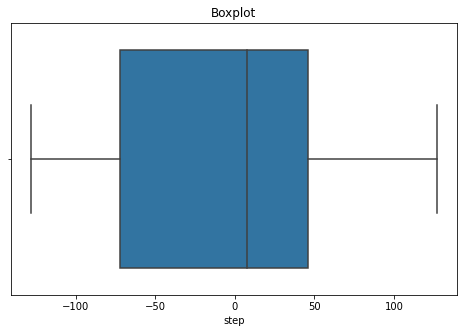

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


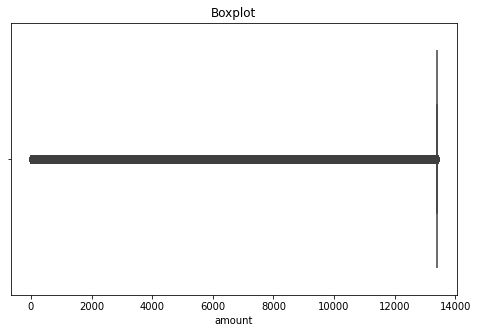

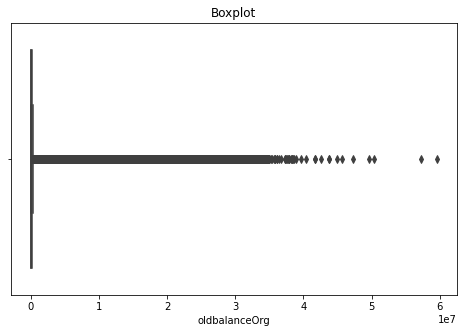

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


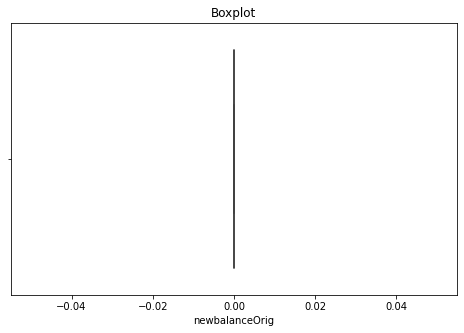

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


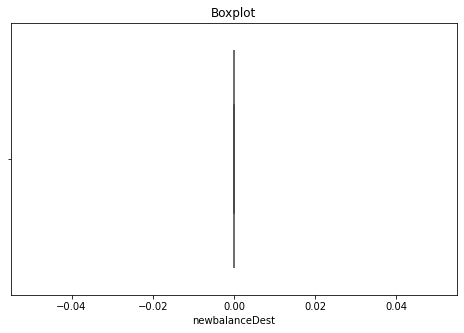

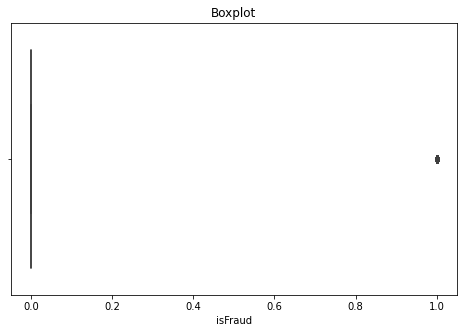

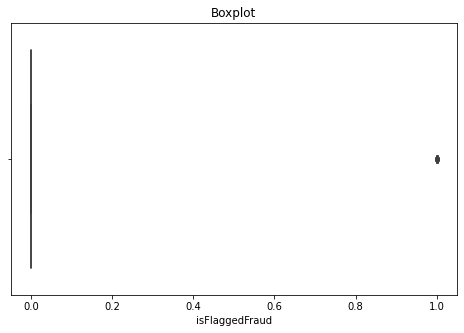

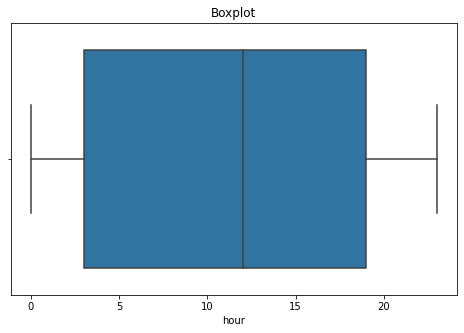

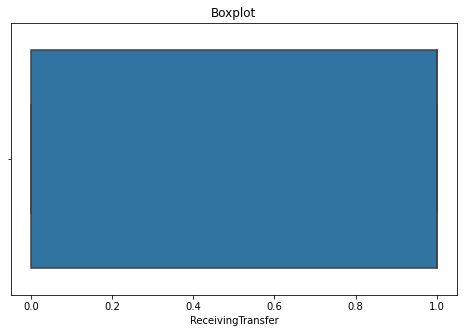

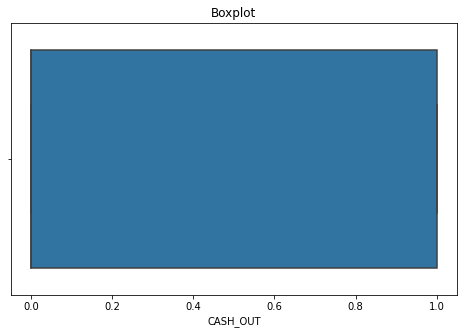

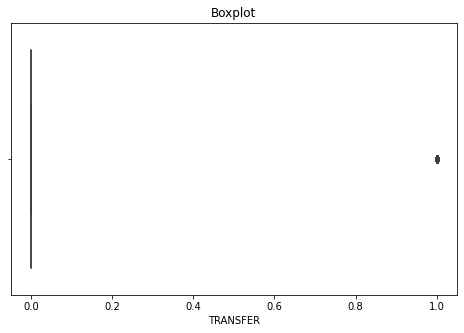

In [ ]:
def box_plot(col):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=data_new[col])
    plt.title('Boxplot')
    plt.show()
    
for col in num_cols:
    box_plot(col)

In [ ]:
for col in num_cols:
    mean = data_new[col].mean()
    std = data_new[col].std()

    upper_limit = mean+3*std
    lower_limit = mean-3*std

    data = data_new[(data_new[col]<upper_limit) & (data_new[col]>lower_limit)]

data.shape

(5829711, 17)

In [ ]:
data = data_new.copy()

In [ ]:
data.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,newbalanceDest,isFraud,isFlaggedFraud,type1,typeOrigAccount,typeDestAccount,hour,ReceivingTransfer,CASH_OUT,TRANSFER
214936,13,CASH_OUT,inf,C638608132,13651.0,0.0,C1687844929,inf,0,0,CC,C,C,13,0.0,1.0,0.0
3163433,-19,TRANSFER,inf,C529857760,0.0,0.0,C1945745009,inf,0,0,CC,C,C,5,0.0,0.0,1.0
3275431,-5,CASH_OUT,inf,C1478305619,0.0,0.0,C535216763,inf,0,0,CC,C,C,19,0.0,1.0,0.0
4859115,92,CASH_OUT,inf,C2058376034,118568.0,0.0,C324838247,inf,0,0,CC,C,C,20,0.0,1.0,0.0
2337208,-67,CASH_OUT,inf,C913458499,0.0,0.0,C1530614289,inf,0,0,CC,C,C,5,0.0,1.0,0.0


In [ ]:
data_new.loc[data_new['hour'] <= 7, 'time'] = 'NGHT'
data_new.loc[((data_new['hour'] > 7) & (data_new['hour'] <=12)), 'time'] = 'MRNG'
data_new.loc[((data_new['hour'] > 12) & (data_new['hour'] <=18)), 'time'] = 'DAY'
data_new.loc[((data_new['hour'] > 18) & (data_new['hour'] <=23)), 'time'] = 'EVE'
data_new.time.unique()

array(['NGHT', 'MRNG', 'DAY', 'EVE'], dtype=object)

In [ ]:
data_new.time = pd.Categorical(data_new.time, ['NGHT', 'MRNG', 'DAY', 'EVE'])

In [ ]:
'''plt.figure(figsize=(8,6))
sns.barplot(data = data, x='type', y='amount')
plt.title('Total amount sent by transaction type')
plt.xlabel('Transaction type')
plt.ylabel('Total amount of transaction');

plt.figure(figsize=(8,6))
sns.countplot(data = data, x='type')
plt.title('Total number of fraud transactions by transaction type')
plt.xlabel('Transaction type')
plt.ylabel('Total number of transactions');'''

"plt.figure(figsize=(8,6))\nsns.barplot(data = data, x='type', y='amount')\nplt.title('Total amount sent by transaction type')\nplt.xlabel('Transaction type')\nplt.ylabel('Total amount of transaction');\n\nplt.figure(figsize=(8,6))\nsns.countplot(data = data, x='type')\nplt.title('Total number of fraud transactions by transaction type')\nplt.xlabel('Transaction type')\nplt.ylabel('Total number of transactions');"

**Data Preparation for Modeling**

In [ ]:
data_new.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,newbalanceDest,isFraud,isFlaggedFraud,type1,typeOrigAccount,typeDestAccount,hour,ReceivingTransfer,CASH_OUT,TRANSFER,time
0,1,PAYMENT,9840.0,C1231006815,170136.0,inf,M1979787155,0.0,0,0,CM,C,M,1,1.0,0.0,0.0,NGHT
1,1,PAYMENT,1864.0,C1666544295,21249.0,19392.0,M2044282225,0.0,0,0,CM,C,M,1,1.0,0.0,0.0,NGHT
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,1,0,CC,C,C,1,0.0,0.0,1.0,NGHT
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,0.0,1,0,CC,C,C,1,0.0,1.0,0.0,NGHT
4,1,PAYMENT,11672.0,C2048537720,41554.0,29888.0,M1230701703,0.0,0,0,CM,C,M,1,1.0,0.0,0.0,NGHT


In [ ]:
data_new[data_new['isFraud'] == 1]['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

In [ ]:
data_new[data_new['isFraud'] == 0]['type'].value_counts()

CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64

In [ ]:
data_new['time'].value_counts()

NGHT    2631541
EVE     1951009
DAY     1102223
MRNG     677847
Name: time, dtype: int64

In [ ]:
df_model_dum = data_new.copy()
df_model_dum[['NGHT', 'MRNG', 'DAY', 'EVE']] = pd.get_dummies(df_model_dum['time'])


In [ ]:
df_model_dum.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,newbalanceDest,isFraud,isFlaggedFraud,...,typeDestAccount,hour,ReceivingTransfer,CASH_OUT,TRANSFER,time,NGHT,MRNG,DAY,EVE
0,1,PAYMENT,9840.0,C1231006815,170136.0,inf,M1979787155,0.0,0,0,...,M,1,1.0,0.0,0.0,NGHT,1,0,0,0
1,1,PAYMENT,1864.0,C1666544295,21249.0,19392.0,M2044282225,0.0,0,0,...,M,1,1.0,0.0,0.0,NGHT,1,0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,1,0,...,C,1,0.0,0.0,1.0,NGHT,1,0,0,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,0.0,1,0,...,C,1,0.0,1.0,0.0,NGHT,1,0,0,0
4,1,PAYMENT,11672.0,C2048537720,41554.0,29888.0,M1230701703,0.0,0,0,...,M,1,1.0,0.0,0.0,NGHT,1,0,0,0


In [ ]:
df_model_dum.loc[df_model_dum['typeDestAccount'] == 'C', 'CustomerDestAccount'] = '1'
df_model_dum.loc[df_model_dum['typeDestAccount'] != 'C', 'CustomerDestAccount'] = '0'
df_model_dum = df_model_dum.drop(['typeDestAccount'], axis =1)

In [ ]:
df_model_dum.loc[df_model_dum['typeOrigAccount'] == 'C', 'CustomerorigAccount'] = '1'
df_model_dum.loc[df_model_dum['typeOrigAccount'] != 'C', 'CustomerorigAccount'] = '0'
df_model_dum = df_model_dum.drop(['typeOrigAccount'], axis =1)

In [ ]:
df_model_dum.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type1',
       'hour', 'ReceivingTransfer', 'CASH_OUT', 'TRANSFER', 'time', 'NGHT',
       'MRNG', 'DAY', 'EVE', 'CustomerDestAccount', 'CustomerorigAccount'],
      dtype='object')

In [ ]:
df_model_dum.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,newbalanceDest,isFraud,isFlaggedFraud,...,ReceivingTransfer,CASH_OUT,TRANSFER,time,NGHT,MRNG,DAY,EVE,CustomerDestAccount,CustomerorigAccount
0,1,PAYMENT,9840.0,C1231006815,170136.0,inf,M1979787155,0.0,0,0,...,1.0,0.0,0.0,NGHT,1,0,0,0,0,1
1,1,PAYMENT,1864.0,C1666544295,21249.0,19392.0,M2044282225,0.0,0,0,...,1.0,0.0,0.0,NGHT,1,0,0,0,0,1
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,1,0,...,0.0,0.0,1.0,NGHT,1,0,0,0,1,1
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,0.0,1,0,...,0.0,1.0,0.0,NGHT,1,0,0,0,1,1
4,1,PAYMENT,11672.0,C2048537720,41554.0,29888.0,M1230701703,0.0,0,0,...,1.0,0.0,0.0,NGHT,1,0,0,0,0,1


In [ ]:
df_model_dum.drop(['type','step','isFlaggedFraud','nameOrig','nameDest','hour','time'], axis = 1, inplace= True)
df_model_dum.head()

,amount,oldbalanceOrg,newbalanceOrig,newbalanceDest,isFraud,type1,ReceivingTransfer,CASH_OUT,TRANSFER,NGHT,MRNG,DAY,EVE,CustomerDestAccount,CustomerorigAccount
0,9840.0,170136.0,inf,0.0,0,CM,1.0,0.0,0.0,1,0,0,0,0,1
1,1864.0,21249.0,19392.0,0.0,0,CM,1.0,0.0,0.0,1,0,0,0,0,1
2,181.0,181.0,0.0,0.0,1,CC,0.0,0.0,1.0,1,0,0,0,1,1
3,181.0,181.0,0.0,0.0,1,CC,0.0,1.0,0.0,1,0,0,0,1,1
4,11672.0,41554.0,29888.0,0.0,0,CM,1.0,0.0,0.0,1,0,0,0,0,1


In [ ]:
df_model_dum["CustomerDestAccount"] = pd.to_numeric(df_model_dum["CustomerDestAccount"])

In [ ]:
df_model_dum["CustomerorigAccount"] = pd.to_numeric(df_model_dum["CustomerorigAccount"])

In [ ]:
X = df_model_dum.drop('isFraud', axis=1)
y = df_model_dum['isFraud']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    stratify=y, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4453834, 14)
(1908786, 14)
(4453834,)
(1908786,)


#### MinMaxScaler -

For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.

MinMaxScaler preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data.

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Logistic Regression**

In [ ]:
 logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

#### Confusion Matrix -

In [ ]:
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)

#### Classification Report -

In [ ]:
print(classification_report(y_test, y_pred))

#### ROC Curve -

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

- TPR=(TP)/(TP+FN)

False Positive Rate (FPR) is defined as follows:

- FPR=(FP)/(FP+TN) 

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

#### AUC (Area under the ROC Curve) -

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).


AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions:

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, logreg.predict_proba(X_test)[:,1])

### Multicollinearity check using Variance Inflation Factor (VIF) -

Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model. Multicollinearity can be a problem in a regression model because we would not be able to distinguish between the individual effects of the independent variables on the dependent variable.

Multicollinearity can be detected via various methods. One such method is Variance Inflation Factor aka VIF.
In VIF method, we pick each independent feature and regress it against all of the other independent features.
VIF score of an independent variable represents how well the variable is explained by other independent variables.

VIF = 1/1-R2

In [ ]:
def calc_vif(X):
    # Calculating the VIF
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending = False)
    return vif

calc_vif(X)

In [ ]:
X.drop(columns=['ReceivingTransfer','CASH_OUT','TRANSFER','NGHT','MRNG','DAY','EVE','newbalanceOrig','oldbalanceOrg'], axis=1, inplace=True)

In [ ]:
X = scaler.fit_transform(X)

kfold = KFold(n_splits=5)
accuracy = np.mean(cross_val_score(logreg, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)) 
print("Cross Validation accuracy: {:.3f}".format(accuracy))

### Oversampling using SMOTE

In [ ]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [ ]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

In [ ]:
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X_train_res, y_train_res)
predictions = lr1.predict(X_test)
  
# Classification Report
print(classification_report(y_test, predictions))

In [ ]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr1.predict_proba(X_test)[:,1])

In [ ]:
#alternative method
#We can try fixing the imbalance using class weights as well